In [1]:
import os
import json
import glob
import random
import collections

import numpy as np
import pandas as pd
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut, apply_modality_lut
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers

In [2]:
IMAGE_SIZE = 256
TYPES = ["FLAIR", "T1w", "T2w", "T1wCE"]
# WHITE_THRESHOLD = 10 # out of 255
EXCLUDE = [109, 123, 709]

KERNEL_SIZE = (3,3)

base_path = 'D:\zerobase\Brain_tumor'

FILENAME = '36_best_model_2dcnn_t1wce_size256_grad_test.h5'
IMAGETYPE = 'T1wCE'

train_df = pd.read_csv(base_path + "/train_df.csv")
valid_df = pd.read_csv(base_path + '/test_df.csv')
train_df = train_df[~train_df.BraTS21ID.isin(EXCLUDE)]

In [3]:
train_df

,BraTS21ID,MGMT_value
0,185,1
1,816,1
2,707,1
3,683,0
4,6,1
...,...,...
463,356,0
464,89,1
465,217,0
466,834,0


In [4]:
X_train, X_test, y_train, y_test = train_test_split(train_df['BraTS21ID'],train_df['MGMT_value'], test_size=0.2, stratify=train_df['MGMT_value'])
train_df = pd.DataFrame({'BraTS21ID' : X_train,'MGMT_value':y_train})
test_df = pd.DataFrame({'BraTS21ID' : X_test,'MGMT_value':y_test})

test_df_id = test_df['BraTS21ID']

In [5]:
# X, test_X, y, test_y = train_test_split(train_df['BraTS21ID'], train_df['MGMT_value'], test_size=0.2, random_state=13, stratify=train_df['MGMT_value'])
# train_df = pd.DataFrame({'BraTS21ID':X, 'MGMT_value':y})
# test_df = pd.DataFrame({'BraTS21ID':test_X, 'MGMT_value':test_y})

In [6]:
# def load_dicom(path, size = 224):
def load_dicom(path, IMAGE_SIZE):
    ''' 
    Reads a DICOM image, standardizes so that the pixel values are between 0 and 1, then rescales to 0 and 255
    
    Note super sure if this kind of scaling is appropriate, but everyone seems to do it. 
    '''
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
#     print('read dicom file : ' , path)
    
#     data = apply_modality_lut(data, dicom)   # modality 적용
#     data = apply_voi_lut(data,dicom)         # voi 적용
    
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    
    k = cv2.getStructuringElement(cv2.MORPH_RECT,KERNEL_SIZE)  # tophat or gradient 적용시 활성화
#     data = cv2.morphologyEx(data, cv2.MORPH_TOPHAT, k)       # tophat 적용
    data = cv2.morphologyEx(data, cv2.MORPH_GRADIENT, k)       # gradient 적용
    
    return cv2.resize(data, (IMAGE_SIZE, IMAGE_SIZE))

def get_all_image_paths(brats21id, image_type, folder='train'): 
    '''
    Returns an arry of all the images of a particular type for a particular patient ID
    '''
    assert(image_type in TYPES), '이미지 타입 이름을 확인하세요'
    
    patient_path = os.path.join(
        base_path + "/%s/" % folder, 
        str(brats21id).zfill(5),
    )

    paths = sorted(
        glob.glob(os.path.join(patient_path, image_type, "*")), 
        key=lambda x: int(x[:-4].split("-")[-1]),
    )
    
    num_images = len(paths)
    
    start = int(num_images * 0.25)
    end = int(num_images * 0.75)

    interval = 3
    
    if num_images < 10: 
        interval = 1
    
    return np.array(paths[start:end:interval])

def get_all_images(brats21id, image_type, folder='train', size = IMAGE_SIZE):
    return [load_dicom(path, size) for path in get_all_image_paths(brats21id, image_type, folder)]


def get_all_data_for_train(image_type):
    global train_df
    
    X = []
    y = []
    train_ids = []

    for i in tqdm(train_df.index):
        x = train_df.loc[i]
        images = get_all_images(int(x['BraTS21ID']), image_type, 'train', IMAGE_SIZE)
        label = x['MGMT_value']

        X += images
        y += [label] * len(images)
        train_ids += [int(x['BraTS21ID'])] * len(images)
        assert(len(X) == len(y))
    return np.array(X), np.array(y), np.array(train_ids)

def get_all_data_for_val(image_type):
    global valid_df
    
    X = []
    y = []
    valid_ids = []

    for i in tqdm(valid_df.index):
        x = valid_df.loc[i]
        images = get_all_images(int(x['BraTS21ID']), image_type, 'train', IMAGE_SIZE)
        label = x['MGMT_value']
        
        X += images
        y += [label] * len(images)
        valid_ids += [int(x['BraTS21ID'])] * len(images)
        assert(len(X) == len(y))
    return np.array(X), np.array(y), np.array(valid_ids)

def get_all_data_for_test(image_type):
    global test_df
    
    X = []
    test_ids = []

    for i in tqdm(test_df.index):
        x = test_df.loc[i]
        images = get_all_images(int(x['BraTS21ID']), image_type, 'train', IMAGE_SIZE)
        X += images
        test_ids += [int(x['BraTS21ID'])] * len(images)

    return np.array(X), np.array(test_ids)






In [7]:
X, y, trainidt = get_all_data_for_train(IMAGETYPE)
X_valid, y_valid, trainidt_valid = get_all_data_for_val(IMAGETYPE)
X_test, testidt = get_all_data_for_test(IMAGETYPE)

X = np.concatenate((X, X_valid), axis=0)
y = np.concatenate((y, y_valid), axis=0)
trainidt = np.concatenate((trainidt, trainidt_valid), axis=0) 


X.shape, y.shape, trainidt.shape

  0%|          | 0/372 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

((13348, 256, 256), (13348,), (13348,))

In [8]:
# X_train, X_valid, y_train, y_valid, trainidt_train, trainidt_valid = train_test_split(X, y, trainidt, test_size=0.2, random_state=40, stratify=y)
X_train, X_val, y_train, y_val, trainidt_train, validt= train_test_split(X, y, trainidt, test_size=0.2, stratify=y)

In [9]:
# split = int(X.shape[0] * 0.8)

# X_train = X[:split]
# X_valid = X[split:]

# y_train = y[:split]
# y_valid = y[split:]

# trainidt_train = trainidt[:split]
# trainidt_valid = trainidt[split:]

X_train = tf.expand_dims(X_train, axis=-1)
X_valid = tf.expand_dims(X_valid, axis=-1)

y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, trainidt_train.shape, trainidt_valid.shape

(TensorShape([10678, 256, 256, 1]),
 (10678, 2),
 TensorShape([3368, 256, 256, 1]),
 (3368, 2),
 (10678,),
 (3368,))

In [10]:
# global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# data_augmentation = tf.keras.Sequential([
#   tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
#   tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
# ])

In [11]:
%%time 
np.random.seed(0)
random.seed(12)
tf.random.set_seed(12)

inpt = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))

h = keras.layers.experimental.preprocessing.Rescaling(1./255)(inpt)
# h = data_augmentation(h)

# convolutional layer!
h = keras.layers.Conv2D(32, kernel_size=(3, 3),strides=(1,1), activation="relu", name="Conv_1", padding="valid")(h) 
h = tf.keras.layers.BatchNormalization(axis=-1)(h)
h = keras.layers.Conv2D(64, kernel_size=(3, 3),strides=(1,1), activation="relu", name="Conv_2", padding="same")(h) 
h = tf.keras.layers.BatchNormalization(axis=-1)(h)
# pooling layer
h = keras.layers.MaxPool2D(pool_size=(2,2))(h) 
h = tf.keras.layers.BatchNormalization(axis=-1)(h)
# convolutional layer!
h = keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu", name="Conv_3",padding ="same")(h)
# h = tf.keras.layers.BatchNormalization(axis=-1)(h)
# pooling layer
# h = keras.layers.MaxPool2D(pool_size=(1,1))(h)
h = tf.keras.layers.BatchNormalization(axis=-1)(h)
h = keras.layers.Conv2D(128, kernel_size=(3, 3), activation="relu", name="Conv_4",padding ="valid")(h)
h = tf.keras.layers.BatchNormalization(axis=-1)(h)
h = keras.layers.Conv2D(128, kernel_size=(3, 3), activation="relu", name="Conv_5",padding ="same")(h)
h = tf.keras.layers.BatchNormalization(axis=-1)(h)
h = keras.layers.MaxPool2D(pool_size=(2,2))(h)
h = tf.keras.layers.BatchNormalization(axis=-1)(h)
h = keras.layers.Dropout(0.3)(h)   

h = keras.layers.Flatten()(h) 
# h = global_average_layer(h)
h = keras.layers.Dense(128, activation='relu')(h)   

output = keras.layers.Dense(2, activation="softmax")(h)

model = keras.Model(inpt, output)

from tensorflow.keras.optimizers import SGD
# opt = SGD(lr=0.1)

checkpoint_filepath = FILENAME
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
filepath=checkpoint_filepath,
save_weights_only=False,
monitor='val_auc',
mode='max',
save_best_only=True,
save_freq='epoch')


earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=10)

model.compile(loss='categorical_crossentropy',
             optimizer=tf.keras.optimizers.SGD(learning_rate =0.0001),
             metrics=[tf.keras.metrics.AUC()])

history = model.fit(x=X_train, y = y_train, batch_size=8, epochs=20, callbacks=[model_checkpoint_callback, earlystop], validation_data= (X_valid, y_valid))

Epoch 1/20
1335/1335 [==============================] - 155s 107ms/step - loss: 0.6882 - auc: 0.6212 - val_loss: 0.5988 - val_auc: 0.7811
Epoch 2/20
1335/1335 [==============================] - 142s 106ms/step - loss: 0.5609 - auc: 0.7820 - val_loss: 0.4930 - val_auc: 0.8606
Epoch 3/20
1335/1335 [==============================] - 140s 105ms/step - loss: 0.4357 - auc: 0.8882 - val_loss: 0.3883 - val_auc: 0.9222
Epoch 4/20
1335/1335 [==============================] - 139s 104ms/step - loss: 0.3225 - auc: 0.9489 - val_loss: 0.2649 - val_auc: 0.9752
Epoch 5/20
1335/1335 [==============================] - 139s 104ms/step - loss: 0.2287 - auc: 0.9808 - val_loss: 0.2322 - val_auc: 0.9766
Epoch 6/20
1335/1335 [==============================] - 139s 104ms/step - loss: 0.1602 - auc: 0.9943 - val_loss: 0.1746 - val_auc: 0.9879
Epoch 7/20
1335/1335 [==============================] - 139s 104ms/step - loss: 0.1137 - auc: 0.9982 - val_loss: 0.1418 - val_auc: 0.9919
Epoch 8/20
1335/1335 [============

In [12]:
def get_confusion_matrix(result3, threshold=0.5):

    confusion_matrix = [[0, 0], [0, 0]]

#     for i in range(len(result3)):
#         threshold = 1 if result3.loc[i, "MGMT_value_x"] > threshold else 0
#         confusion_matrix[result3.loc[i, "MGMT_value_y"]][threshold] += 1
        
    for idx, data in result3.iterrows():
        res = 1 if data.MGMT_value_x > threshold else 0
        confusion_matrix[int(data.MGMT_value_y)][res] += 1

    return confusion_matrix

def get_acc_recall(arr):
    acc = sum((arr[0][0], arr[1][1]))/sum((sum(arr[0]), sum(arr[1])))
    recall = arr[1][1] / sum(arr[1])
    print(f"Acc: {acc} \t Recall: {recall}")

In [13]:
def loss(y_true, y_pred):
    return - (1 - theta(y_true - margin) * theta(y_pred - margin)
                - theta(1 - margin - y_true) * theta(1 - margin - y_pred)
             ) * (y_true * K.log(y_pred + 1e-8) + (1 - y_true) * K.log(1 - y_pred + 1e-8))

import tensorflow as tf

margin = 0.6
theta = lambda t: (K.sign(t)+1.)/2.

def mish(inputs):
    x = tf.nn.softplus(inputs)
    x = tf.nn.tanh(x)
    x = tf.multiply(x, inputs)
    return x




model_path = [
 FILENAME,
]

pred_list = []
for path in model_path:
    model_best = tf.keras.models.load_model(filepath=path,custom_objects={"loss":loss,'leaky_relu': tf.nn.leaky_relu,'mish':mish})
    
#     sample = pd.read_csv(base_path + '/test_df.csv')
    y_pred = model_best.predict(X_test)
    #pred = np.argmax(y_pred, axis=1)
    pred_list.append(y_pred)

In [14]:
len(pred_list),pred_list[0].shape, pred_list

(1,
 (2852, 2),
 [array([[0.9851634 , 0.01483663],
         [0.92415583, 0.0758441 ],
         [0.09986763, 0.90013236],
         ...,
         [0.95077467, 0.04922528],
         [0.02318405, 0.97681594],
         [0.82199126, 0.17800881]], dtype=float32)])

In [15]:
sample = pd.read_csv(base_path + '/test_df.csv')
# sample

In [16]:
y_pred = sum(pred_list)/len(pred_list)
pred = np.argmax(y_pred, axis=1)
result=pd.DataFrame(testidt)
result[1]=pred 
result.columns=['BraTS21ID','MGMT_value']
result2 = result.groupby('BraTS21ID',as_index=False).mean()
result2['BraTS21ID'] = list(test_df_id)

result2.to_csv('submission_best_score_2dcnn_test.csv',index=False)
    
result2['MGMT_value_y'] = list(test_df['MGMT_value'])
result2.columns=[['BrsTS21ID','MGMT_value_x','MGMT_value_y']]


In [17]:
len(list(test_df['MGMT_value']))

94

No handles with labels found to put in legend.


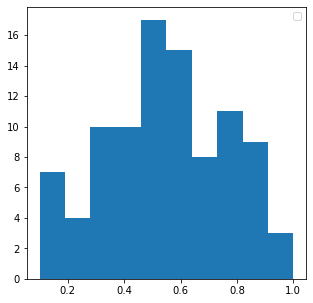

In [18]:
plt.figure(figsize=(5, 5))
plt.hist(result2["MGMT_value_x"])
plt.legend()

In [19]:
arr = get_confusion_matrix(result2)
print(arr)
get_acc_recall(arr)

[[24, 20], [21, 29]]
Acc: 0.5638297872340425 	 Recall: 0.58


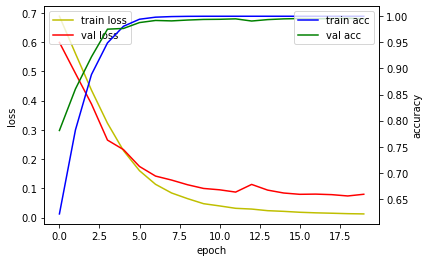

In [21]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['auc'], 'b', label='train acc')
acc_ax.plot(history.history['val_auc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper right')

plt.show()